# 0. Install and Import Dependencies

In [43]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 1. Make Detections

# 2. Determining Joints

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# 3. Calculate Angles

In [44]:
import numpy as np

def minvisibility(objs):
    return min([i.visibility for i in objs])

def obj_to_coord(obj):
    return [obj.x, obj.y, obj.z]

def vector_minus(v1, v2):
    return [v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2]]

def get_angle(v1, v2):
    dot = v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]
    abs_v1 = np.sqrt(v1[0] * v1[0] + v1[1] * v1[1] + v1[2] * v1[2])
    abs_v2 = np.sqrt(v2[0] * v2[0] + v2[1] * v2[1] + v2[2] * v2[2])
    return np.arccos(min(dot / (abs_v1 * abs_v2), 1))

I0000 00:00:1745072139.872389   18421 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1745072139.873700   45172 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.1-arch1.1), renderer: Mesa Intel(R) Graphics (ADL GT2)
W0000 00:00:1745072139.914405   45152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745072139.931941   45158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


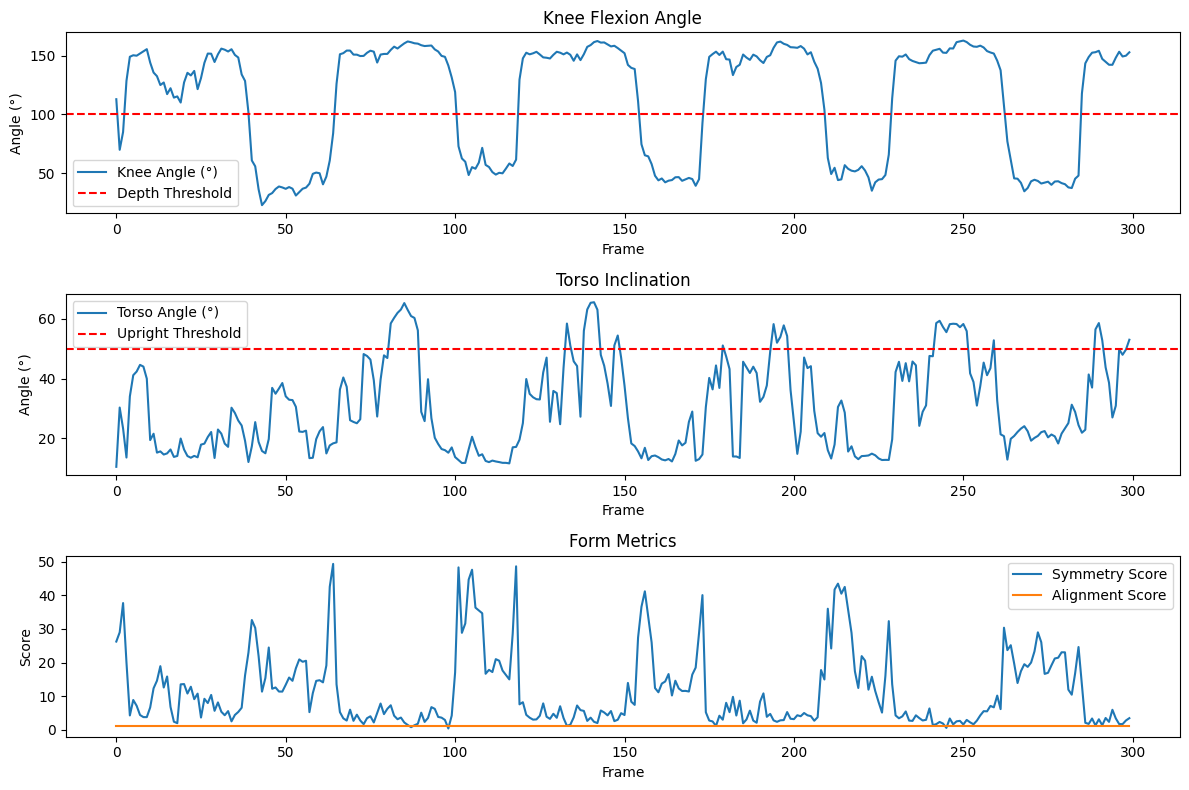

In [43]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

mp_pose    = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def minvisibility(objs):
    return min([i.visibility for i in objs])

def obj_to_coord(obj):
    return np.array([obj.x, obj.y, obj.z])

def vector_minus(v1, v2):
    return v1 - v2

def get_angle(v1, v2):
    dot    = np.dot(v1, v2)
    norm1  = np.linalg.norm(v1)
    norm2  = np.linalg.norm(v2)
    return np.degrees(np.arccos(np.clip(dot / (norm1 * norm2), -1.0, 1.0)))

class EMADictSmoothing:
    def __init__(self, window_size=5, alpha=0.3):
        self.window_size = window_size
        self.alpha       = alpha
        self.reset()

    def reset(self):
        self.buffer = []

    def __call__(self, data_dict):
        self.buffer.append(data_dict.copy())
        while len(self.buffer) > self.window_size:
            self.buffer.pop(0)

        smoothed = {}
        for key in data_dict:
            smoothed[key] = 0.0
            for i, entry in enumerate(reversed(self.buffer)):
                weight = self.alpha * (1 - self.alpha)**i
                smoothed[key] += entry[key] * weight
        return smoothed

cap = cv2.VideoCapture('squat_2.mp4')
ema_smoother = EMADictSmoothing(window_size=5, alpha=0.3)

# existing metrics
knee_angles      = []
torso_angles     = []
hip_angles       = []
symmetry_scores  = []
alignment_scores = []
rep_count        = 0

# NEW: head angle & toe‑distance trackers
head_angles     = []
toe_distances   = []

with mp_pose.Pose(min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        try:
            lm = results.pose_landmarks.landmark

            left_knee     = lm[mp_pose.PoseLandmark.LEFT_KNEE.value]
            right_knee    = lm[mp_pose.PoseLandmark.RIGHT_KNEE.value]
            left_hip      = lm[mp_pose.PoseLandmark.LEFT_HIP.value]
            right_hip     = lm[mp_pose.PoseLandmark.RIGHT_HIP.value]
            left_ankle    = lm[mp_pose.PoseLandmark.LEFT_ANKLE.value]
            right_ankle   = lm[mp_pose.PoseLandmark.RIGHT_ANKLE.value]
            left_shoulder = lm[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
            right_shoulder= lm[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
            nose_pt       = lm[mp_pose.PoseLandmark.NOSE.value]          # NEW

            lk = obj_to_coord(left_knee)
            rk = obj_to_coord(right_knee)
            lh = obj_to_coord(left_hip)
            rh = obj_to_coord(right_hip)
            la = obj_to_coord(left_ankle)
            ra = obj_to_coord(right_ankle)
            ls = obj_to_coord(left_shoulder)
            rs = obj_to_coord(right_shoulder)
            no = obj_to_coord(nose_pt)                                  # NEW

            l_thigh    = vector_minus(lk, lh)
            r_thigh    = vector_minus(rk, rh)
            l_shin     = vector_minus(la, lk)
            r_shin     = vector_minus(ra, rk)
            l_torso_v  = vector_minus(lh, ls)
            r_torso_v  = vector_minus(rh, rs)
            l_hip_v    = vector_minus(lh, ls)
            r_hip_v    = vector_minus(rh, rs)

            # existing angles & scores
            l_knee_ang  = get_angle(l_thigh, l_shin)
            r_knee_ang  = get_angle(r_thigh, r_shin)
            l_torso_ang = get_angle(l_torso_v, [0,1,0])
            r_torso_ang = get_angle(r_torso_v, [0,1,0])
            l_hip_ang   = get_angle(l_thigh, l_hip_v)
            r_hip_ang   = get_angle(r_thigh, r_hip_v)

            avg_knee    = (l_knee_ang + r_knee_ang)/2
            avg_torso   = (l_torso_ang + r_torso_ang)/2
            sym_score   = abs(l_knee_ang - r_knee_ang) + abs(l_torso_ang - r_torso_ang)
            l_align     = abs(la[0] - lk[0]) < 0.1
            r_align     = abs(ra[0] - rk[0]) < 0.1
            align_score = int(l_align and r_align)

            # NEW: head angle (to vertical)
            mid_sho     = (ls + rs) / 2
            head_vec    = no - mid_sho
            head_ang    = get_angle(head_vec, [0,1,0])

            # NEW: toe‑distance = avg horizontal ankle–knee separation
            toe_dist    = (abs(la[0]-lk[0]) + abs(ra[0]-rk[0])) / 2

            if minvisibility([left_knee, right_knee, left_hip, right_hip, left_ankle, right_ankle]) > 0.7:
                # append your old lists
                knee_angles.append(avg_knee)
                torso_angles.append(avg_torso)
                hip_angles.append((l_hip_ang + r_hip_ang)/2)
                symmetry_scores.append(sym_score)
                alignment_scores.append(align_score)

                # append the new trackers
                head_angles.append(head_ang)
                toe_distances.append(toe_dist)

                is_standing = 1 if (avg_knee>160 and avg_torso<30) else 0

                current_pose = {
                    "squat_down": 1 if (np.mean(knee_angles[-5:]) < 100) else 0,
                    "good_form": 1 if (
                        np.mean(torso_angles[-5:]) < 50 and 
                        np.mean(knee_angles[-5:]) < 100 and  
                        align_score == 1 and             
                        sym_score < 50                 
                    ) else 0,
                    "standing": is_standing 
                }

                smoothed = ema_smoother(current_pose)
                if smoothed["squat_down"] >= 0.5 and rep_count % 2 == 0:
                    rep_count += 1
                elif smoothed["squat_down"] < 0.5 and rep_count % 2 == 1:
                    rep_count += 1

                cv2.putText(image, f"Reps: {rep_count//2}", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                if smoothed["squat_down"] >= 0.5:
                    if smoothed["good_form"] >= 0.5:
                        cv2.putText(image, "GOOD SQUAT!", (10, 60),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    else:
                        cv2.putText(image, "BAD FORM!", (10, 60),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,   0, 255), 2)
                else:
                    cv2.putText(image, "Standing", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

        except Exception as e:
            print(f"Error: {e}")

        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        cv2.imshow('Mediapipe Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# your original plots (unchanged) will still work on knee_angles, torso_angles, etc.
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(knee_angles, label='Knee Angle (°)')
plt.axhline(y=100, color='r', linestyle='--', label='Depth Threshold')
plt.title('Knee Flexion Angle')
plt.xlabel('Frame')
plt.ylabel('Angle (°)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(torso_angles, label='Torso Angle (°)')
plt.axhline(y=50, color='r', linestyle='--', label='Upright Threshold')
plt.title('Torso Inclination')
plt.xlabel('Frame')
plt.ylabel('Angle (°)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(symmetry_scores, label='Symmetry Score')
plt.plot(alignment_scores, label='Alignment Score')
plt.title('Form Metrics')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()




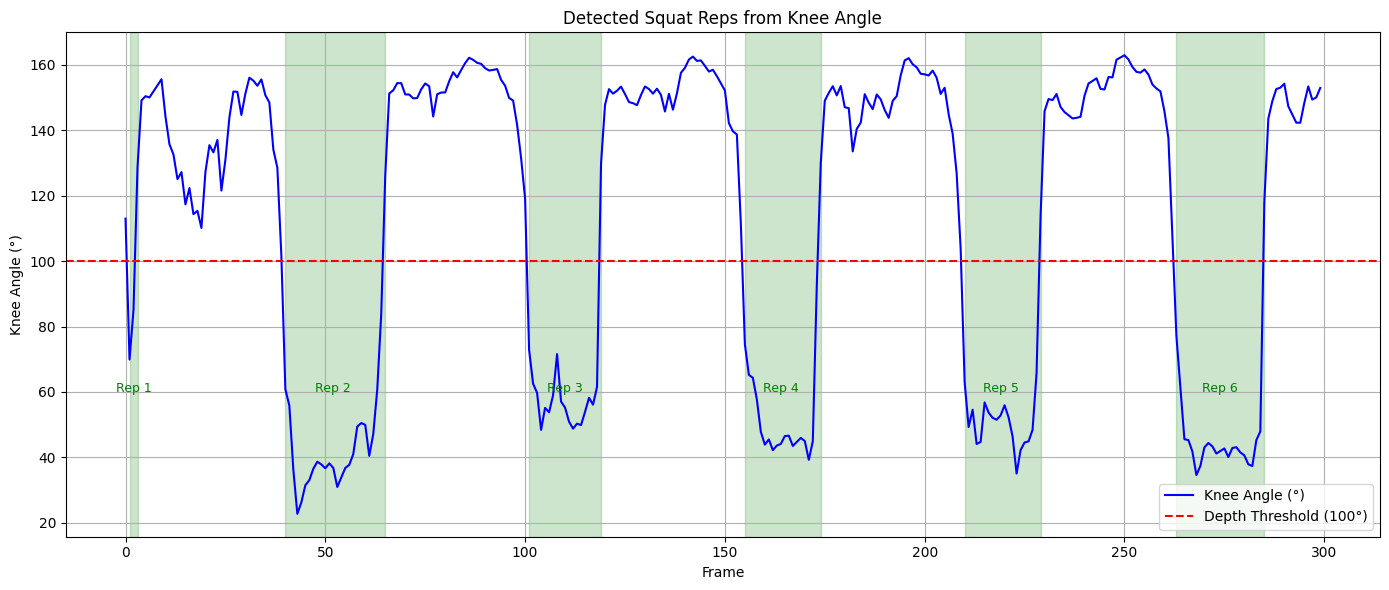

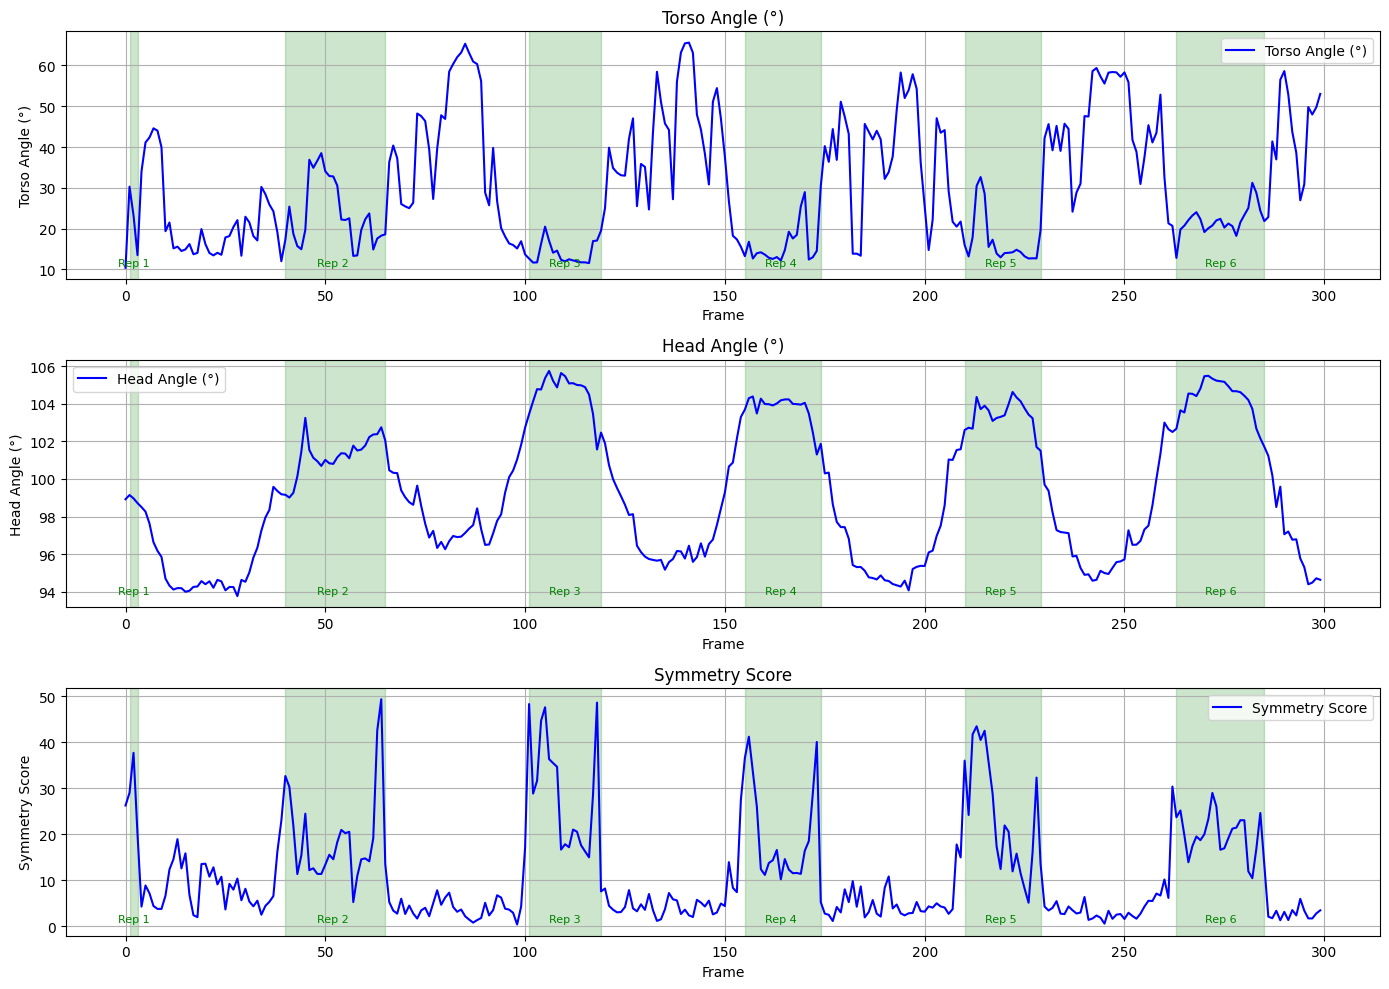

In [47]:
import matplotlib.pyplot as plt
import numpy as np

ka = np.array(knee_angles)
THRESH = 100.0

down_idxs = np.where((ka[:-1] >= THRESH) & (ka[1:] < THRESH))[0] + 1
up_idxs   = np.where((ka[:-1] <= THRESH) & (ka[1:] > THRESH))[0] + 1

rep_ranges = []
j = 0
for down in down_idxs:
    while j < len(up_idxs) and up_idxs[j] <= down:
        j += 1
    if j < len(up_idxs):
        rep_ranges.append((down, up_idxs[j]))
        j += 1

plt.figure(figsize=(14, 6))
plt.plot(ka, label='Knee Angle (°)', color='blue')
plt.axhline(y=THRESH, color='r', linestyle='--', label='Depth Threshold (100°)')

for i, (start, end) in enumerate(rep_ranges):
    plt.axvspan(start, end, color='green', alpha=0.2)
    plt.text((start + end) // 2, 60, f'Rep {i+1}', color='green', ha='center', fontsize=9)

plt.title('Detected Squat Reps from Knee Angle')
plt.xlabel('Frame')
plt.ylabel('Knee Angle (°)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
metrics = {
    "Torso Angle (°)": np.array(torso_angles),
    "Head Angle (°)":  np.array(head_angles),
    "Symmetry Score":  np.array(symmetry_scores)
}

plt.figure(figsize=(14, 10))

for i, (label, data) in enumerate(metrics.items()):
    plt.subplot(len(metrics), 1, i+1)
    plt.plot(data, label=label, color='blue')

    for idx, (start, end) in enumerate(rep_ranges):
        plt.axvspan(start, end, color='green', alpha=0.2)
        plt.text((start + end) // 2, np.min(data), f'Rep {idx+1}', color='green',
                 ha='center', fontsize=8, va='bottom')

    plt.title(label)
    plt.xlabel('Frame')
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()



In [54]:
import json

rep_data = []

for idx, (start, end) in enumerate((rep_ranges)):
    rep_metrics = {
        "rep_number": int(idx + 1),
        "start_frame": int(start),
        "end_frame": int(end),
        "knee_angle":       [float(val) for val in knee_angles[start:end+1]],
        "torso_angle":      [float(val) for val in torso_angles[start:end+1]],
        "hip_angle":        [float(val) for val in hip_angles[start:end+1]],
        "symmetry_score":   [float(val) for val in symmetry_scores[start:end+1]],
        "alignment_score":  [float(val) for val in alignment_scores[start:end+1]],
        "head_angle":       [float(val) for val in head_angles[start:end+1]],
        "toe_distance":     [float(val) for val in toe_distances[start:end+1]]
    }
    rep_data.append(rep_metrics)

with open("rep_metrics.json", "w") as f:
    json.dump(rep_data, f, indent=2)
